<a href="https://colab.research.google.com/github/Pablo-Lemos/orbits/blob/master/colab_orbits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install graph_nets matplotlib scipy "tensorflow>=1.15,<2" "dm-sonnet<2" "tensorflow_probability<0.9"

In [4]:
import time
import sys

import tensorflow_probability

from graph_nets import blocks
from graph_nets import utils_np
from graph_nets import utils_tf
from graph_nets.demos import models
from graph_nets import modules
from matplotlib import pyplot as plt
import numpy as np
from copy import deepcopy

import random as rand

import graph_nets as gn
import sonnet as snt
import tensorflow as tf
import networkx as nx

# Load functions

In [11]:
#@title simulate_orbits.py

import pandas as pd

#Define constants
AU = 149.6e6 * 1000     # Astronomical Unit in meters.
DAY = 24*3600. # Day in seconds
YEAR = 365.25*DAY
MSUN = 1.98892 * 10**30 # Solar mass
MEARTH = 5.9742 * 10**24 # Earth mass
G = 6.67428e-11/AU**3*MSUN*YEAR**2 # The gravitational constant G in AU**3 /MSUN/ YEAR^2

class Body:
    """
    A class to represent astronomical bodies (e.g. planets and stars)
    Attributes
    ---------- 
    name : str
        the name of the body
    mass : float
        mass in kg
    pos : float(3) 
        position of the body as array (x,y,z) in m
    vel : float(3) 
        velcity of the body as array (vx, vy, vz) in m/s
    acc : float(3) 
        acceleration of the body as array (ax, ay, az) in m/s^2
    orbit : ls
        a list where the orbit is stored
    Methods
    -------
    interaction(other) 
        Returns the acceleration due to gravitational interaction with another
        body
    update(delta_time)
        Updates the position and velocity of the body after a time step
    """
    
    def __init__(self):
        """
        Parameters
        ---------- 
        name : str
            the name of the body
        mass : float
            mass in kg
        pos : float(3) 
            position of the body as array (x,y,z) in m
        vel : float(3) 
            velocity of the body as array (vx, vy, vz) in m/s
        acc : float(3) 
            acceleration of the body as array (ax, ay, az) in m/s^2
        orbit : ls
            a list where the orbit is stored
        """

        self.name = "" 
        self.mass = 0.
        self.pos = np.zeros(3)
        self.vel = np.zeros(3)
        self.acc = np.zeros(3)
        self.orbit = []
    def initiate(self, radial_pos, total_vel):
        """
        Randomly generate an initial position and velocity given a radial position
        and a total velocity. 
        """

        # Create unitary vector, for now, we keep z = 0
        u = random_two_vector()

        # Define the initial position
        x, y = radial_pos*u
        z = 0.

        # Define the initial velocity 
        vy, vx = total_vel*u

        self.pos = np.array([x, y, 0])
        self.vel = np.array([vx, -vy, 0])

    def interaction(self, other):
        """Returns the acceleration due to gravitational interaction with 
        another body
        
        Parameters 
        ----------
        other : Body
            The astronomical body whose gravitational pull we are computing
        """
    
        # Compute distance to the other body
        delta_pos = other.pos - self.pos
        dist = np.sum(delta_pos**2.)**0.5
        
        #Calculate the acceleration using Newtonian Gravity
        self.acc += G*other.mass*delta_pos/dist**3.

    def update(self, delta_time):
        """Updates the position and velocity of the body after a time step
        Parameters
        ----------
        delta_t : float 
            The size of the time step in seconds
        """

        self.vel += self.acc*delta_time
        self.pos += self.vel*delta_time

def random_two_vector():
    """
    Generates a random 2D unitary vector
    Returns:
    --------
    x,y: float
        Coordinates of the unitary vector (x^2 + y^2 = 1)
    """
    phi = np.random.uniform(0,np.pi*2)
    x = np.cos(phi)
    y = np.sin(phi)
    return np.array([x,y])

def simulate(bodies, total_time, delta_time):
    """
    Simulates the orbits for a certain period of time, and stores the results
    as a panda array. 
 
    Parameters
    ----------
    bodies : list
        The bodies that will interact in the simulation
    total_time : float
        The amount of time (in seconds) that the simulation will last for
    time_step : float
        The size of the time steps in the simulation in seconds
    """

    time = 0 # Current time

    while time<total_time: 
        for body in bodies: 
            body.acc = (0,0,0) # Restart acceleration
            for other_body in bodies: 
                if body is not other_body: # Not sum over interaction with self
                    # Sum over interactions with all other bodies
                    body.interaction(other_body) 

            body.update(delta_time) # Update position and velocity of each body
            body.orbit.append(np.concatenate(
             (body.pos, body.vel))) # Store position of each body (in AU)

        time += delta_time # Update total time

    # Create the pandas DataFrame for each orbit
    orbits = []
    for body in bodies:
        file_name = './'+body.name # File name to use for saving
        
        # Store as pandas array
        # df = pd.DataFrame(body.orbit, columns = ['x[AU]', 'y[AU]', 'z[AU]'])
        # df.to_pickle(file_name)
 
        # Store as numpy array
        orbits.append(np.asarray(body.orbit)) #convert orbit into numpy array

    np.save(file_name, orbits)#, header = 'x[AU]', 'y[AU]', 'z[AU]') 

def main():
    """
    The main function. Defines the bodies and parameters to be used in the simulation, 
    and starts it
    """

    delta_time = 1*DAY/YEAR # The time interval to be used in years
    total_time = 400*DAY/YEAR # Total time of the Simulation in years

    # Define Astronomical bodies. Data taken from: 
    # http://nssdc.gsfc.nasa.gov/planetary/factsheet/

    # Sun
    sun = Body() 
    sun.name = 'Sun'
    sun.mass = 1./SUN # Solar masses
    sun.pos = np.zeros(3)  
    sun.vel = np.zeros(3) 

    # Mercury
    mercury = Body()
    mercury.name = 'Mercury'
    mercury.mass = 0.33011 * 10**24/MSUN # Solar masses
    mercury.pos = np.array([0.387, 0., 0.]) #AU
    mercury.vel = np.array([0., -47.36 * 1000/AU*YEAR, 0.]) #AU/YEAR 

    #Venus
    venus = Body()
    venus.name = 'Venus'
    venus.mass = 4.8685 * 10**24/MSUN # Solar masses
    venus.pos = np.array([0.723, 0., 0.]) #AU
    venus.vel = np.array([0.,-35.02 * 1000/AU*YEAR, 0.]) #AU/Y

    # Earth
    earth = Body()
    earth.name = 'Earth'
    earth.mass = MEARTH/MSUN # Solar masses
    earth.pos = np.array([-1.,0.,0.]) # AU
    earth.vel = np.array([0.,29.783*1000/AU*YEAR,0.])# AU/Y

    #Run the simulation
    simulate([sun, mercury, venus, earth], total_time, delta_time)

In [8]:
#@title functions for learning

def get_orbital_velocity(radius, mass_planet, mass_star, G, ellipcity_noise = 0):
    """Calculate the initial velocity required to keep an orbit

    Parameters
    ---------- 
    radius : float
      the radial distance from the body to the center of the orbit
    mass_planet : float
      mass of the planet orbiting
    mass_star : float
      mass of the body at the center of the orbit
    G : float 
      Gravitational Constant
    noise: float
      The maximum fractional amount by which the initial velocity is perturbed. 
      Defaults to zero

    Returns
    ---------- 
    velocity : float
      the orbital velocity

    """

    velocity = np.sqrt(G*mass_star/radius)

    # Add noise
    if ellipcity_noise > 0:
        delta_vel = np.random.normal(0, ellipcity_noise, size = np.shape(velocity))
        velocity *= (1.+delta_vel)

    return np.array(velocity)

def get_trajectory(planets, num_time_steps):
    '''
    Calculate real trajectory using Euler integration
    
    Parameters
    ----------
    planets : ls
        A list of planets using the Body class
    num_time_steps : float
        The number of integration steps    
      
    Returns
    -------
    x_traj, p_traj: np.array([num_time_steps, nplanets, 2])
        The positions and momenta of the trajectory for each planet
    '''
    
    nplanets = len(planets)
    x_traj = np.zeros([num_time_steps, nplanets, 2])
    p_traj = np.zeros([num_time_steps, nplanets, 2])
    for i in range(num_time_steps):
        pos = []
        mom = []
        for planet in planets:
            pos.append(planet.orbit[i][0:2])
            mom.append(planet.orbit[i][3:5]*planet.mass)
        
        x_traj[i] = np.array(pos) #km
        p_traj[i] = np.array(mom)#km/s

    return x_traj, p_traj

def get_input_graph(planets, xtraj, t, noise_level = 0.0):
    '''
    Convert a given time into a GraphNets graph that can be used to train a model
    
    Parameters
    ----------
    planets : ls
        A list of planets using the Body class
    xtraj: np.array([num_time_steps, nplanets, 2])
        The positions and momenta of the trajectory for each planet
    t: int
        The time at which the trajectory is evaluated
    noise_level: float
        Fractional noise added to the training, defaults to 0.05
        
    Returns
    -------
    graph_dict: dict
        A dictionary containing globals, edges, nodes, senders and receivers
    '''
    nplanets = len(planets)
    nodes, edges, senders, receivers = [], [], [], []
    for i in range(nplanets):
        noise_mass = np.random.normal(0, noise_level)
        mass = planets[i].mass#*(1+noise_mass)
        nodes.append([mass]) #Use Mercury's mass for units to normalize
        for j in range(nplanets):
            # I do this instead of if i != j, so the distances and forces are not duplicate, this
            # improves the model. I am basically telling the model that F(ij)=F(ji)
            if i > j:
                d = xtraj[t,j,:] - xtraj[t,i,:]
                if noise_level > 0:
                    noise_dist = tf.random.normal([2], 0, noise_level, tf.float32) 
                    edges.append(d*(1+noise_dist))
                else:
                    edges.append(d)
 
                receivers.append(i)
                senders.append(j)
    
    return{
      "globals": [G],
      "nodes": nodes,
      "edges": edges, 
      "receivers": receivers, 
      "senders": senders 
    }  

def generate_batch_random(planets, x_traj, dp_traj, num_time_steps, batch_size, norm_factor = 1, ellipcity_noise = 0):
    ''' Generate a batch of points randomly chosen for training
    '''
    x_traj_ls = []
    p_traj_ls = []
    dp_traj_ls = []
    traj_len = len(x_traj)
    nplanets = len(planets)
    x_batch_np = np.zeros([batch_size, num_time_steps, nplanets, 2])
    dp_batch_np = np.zeros([batch_size, num_time_steps, nplanets, 2])
    t_array = np.random.choice(traj_len-1, batch_size*num_time_steps)
    k = 0
    for i in range(batch_size):
        for j in range(num_time_steps):
            x_batch_np[i,j] = x_traj[t_array[k]]
            dp_batch_np[i,j] = dp_traj[t_array[k]]
            k+=1
            
    x_batch = tf.convert_to_tensor(x_batch_np, dtype=np.float32)
    dp_batch = tf.convert_to_tensor(dp_batch_np, dtype=np.float32)
    return x_batch, dp_batch

In [9]:
#@title Integration Functions

def get_distances(x, input_graph):
    '''
    Convert positions to distances
    '''
    new_graph = input_graph.replace(nodes = x)
    e1 = blocks.broadcast_sender_nodes_to_edges(new_graph)
    e2 = blocks.broadcast_receiver_nodes_to_edges(new_graph)
    dx = e1 - e2
    return dx

def model_gn(dx, input_graph, num_processing_steps, normalization = 1):
    '''
    Use the model to go from dx to dp
    '''
    graph = input_graph.replace(edges = dx)
    outputs = model(graph, num_processing_steps)
    outputs_p = get_momentum_update(outputs)
    output = sum(outputs_p)/num_processing_steps
    dp = output*normalization

    edges = [output.edges for output in outputs]
    forces_unnorm = sum(edges)/num_processing_steps
    forces = forces_unnorm*normalization
    return dp, forces

def get_leapfrog_step(x0, ph, delta_time, input_graph, model, num_processing_steps, normalization = 1):
    
    delta_x = delta_time/input_graph.nodes
    
    x1 = x0 + ph*delta_x
    
    dx = get_distances(x0, input_graph)
    
    dp, force = model(dx, input_graph, num_processing_steps, normalization)
    ph3 = ph + dp

    return x1, ph3, dp, force

def leapfrog_integration(x0, p0, delta_time, input_graph, num_steps, model, num_processing_steps, normalization = 1):
    '''
    Learn the orbit through leapfrom integration
    '''
    def body(i, x0, p0, x_pred, dp_pred, f_pred):
        x, ph, dp, force =  get_leapfrog_step(
            x0, p0, delta_time, 
            input_graph, 
            model, 
            num_processing_steps, 
            normalization)
        return i+1, x, ph, x_pred.write(i, x), dp_pred.write(i-1, dp/normalization), f_pred.write(i-1, force)
    
    # Distance
    dx = get_distances(x0, input_graph)

    # Model predict*norm_p = F*dt
    # (ph = phalf)
    dph, fh = model(dx, input_graph, num_processing_steps, normalization)
    ph = p0 + 0.5*dph
    x = tf.identity(x0)
    
    i = 0

    x_pred = tf.TensorArray(
      dtype=tf.float32, size=num_steps, element_shape=x0.shape)
    dp_pred = tf.TensorArray(
      dtype=tf.float32, size=num_steps-1, element_shape=x0.shape)
    f_pred = tf.TensorArray(
      dtype=tf.float32, size=num_steps-1, element_shape=fh.shape)

    x_pred = x_pred.write(0, x0)
    
    _, _, _, x_pred, dp_pred, f_pred = tf.while_loop(
    lambda i, *unused_args: i < num_steps,
        body,
        loop_vars = [1, x0, ph, x_pred, dp_pred, f_pred]
    )
    return x_pred.stack(), dp_pred.stack(), f_pred.stack()

# Input parameters

In [15]:
#@title generate training data

# Global constants
DAY = 24*3600. # Day in seconds
YEAR = 365.25*DAY #Year
delta_time = (2/24.)*DAY/YEAR # 2 hours
#delta_time = 0.1*DAY/YEAR # 1 hour

total_time_traj = 10 #Years
num_time_steps_total = int(total_time_traj/delta_time)
num_time_steps_test = 4000

batch_size_tr = 500
total_time_tr = 200*delta_time
num_time_steps_tr = int(total_time_tr/delta_time)

batch_size_table = 50
total_time_table = 200*delta_time
num_time_steps_table = int(total_time_table/delta_time)

num_processing_steps_tr = 1
patience = 20
d_patience = 1e-5
#d_patience = 0
noise_level = 0.05

# How much time between logging and printing the current results.
log_every_iterations = 1000
num_training_iterations = 150000

sun = Body()
sun.name = 'Sun'
sun.mass = 1 # solar masses
sun.pos = np.zeros(3) 

mercury = Body()
mercury.name = 'Mercury'
mercury.mass = 0.33011 * 10**24/MSUN # Earth masses
pos_mercury = 0.387 # AU
vel_mercury = get_orbital_velocity(pos_mercury, 
                                   mercury.mass, 
                                   sun.mass, 
                                   G,
                                   ellipcity_noise = 0.01
                                  )
mercury.initiate(pos_mercury, vel_mercury)
    
venus = Body()
venus.name = 'Venus'
venus.mass = 4.8685 * 10**24/MSUN # Earth masses
pos_venus = 0.723 # AU
vel_venus = get_orbital_velocity(pos_venus, 
                                 venus.mass, 
                                 sun.mass, 
                                 G,
                                ellipcity_noise = 0.01)
venus.initiate(pos_venus, vel_venus)

earth = Body()
earth.name = 'Earth'
earth.mass =MEARTH/MSUN # Earth masses
pos_earth = 1 # AU
vel_earth = get_orbital_velocity(pos_earth, 
                                 earth.mass, 
                                 sun.mass, 
                                 G, 
                                ellipcity_noise = 0.01)
earth.initiate(pos_earth, vel_earth)

mars = Body()
mars.name = 'Mars'
mars.mass =0.642 * 10**24/MSUN # Earth masses
pos_mars = 1.52341740516 # AU
vel_mars = get_orbital_velocity(pos_mars, 
                                 mars.mass, 
                                 sun.mass, 
                                 G, 
                                ellipcity_noise = 0.01)
mars.initiate(pos_mars, vel_mars)


sun.vel = -(np.array(mercury.vel)*mercury.mass + 
            np.array(venus.vel)*venus.mass +
            np.array(earth.vel)*earth.mass #+
            #np.array(mars.vel)*mars.mass
            )/sun.mass

# Center at zero (improves stability)
sun.pos = -(np.array(mercury.pos)*mercury.mass + 
            np.array(venus.pos)*venus.mass +
            np.array(earth.pos)*earth.mass #+ 
            #np.array(mars.pos)*mars.mass
            )/sun.mass
#sun.pos = np.zeros(3)

planets = [sun, mercury, venus, earth]#, mars]
nplanets = len(planets)
    
planets_gn = deepcopy(planets)

simulate(planets, total_time_traj, delta_time)

x_traj_np, p_traj_np = get_trajectory(planets, num_time_steps_total)
dp_traj_np = p_traj_np[1:] - p_traj_np[:-1]

p_norm = np.std(dp_traj_np)

x_traj_test = tf.convert_to_tensor(x_traj_np[:num_time_steps_test], dtype=np.float32)
p_traj_test = tf.convert_to_tensor(p_traj_np[:num_time_steps_test], dtype=np.float32)
dp_traj_norm = tf.convert_to_tensor(
    dp_traj_np[:num_time_steps_test-1]/p_norm, dtype=np.float32)


x_traj_np_tr = x_traj_np[num_time_steps_test:]
dp_traj_np_tr = dp_traj_np[num_time_steps_test:]/p_norm


input_dict_test = get_input_graph(planets, x_traj_test, 0, noise_level = 0.0)

input_graph_test = utils_tf.data_dicts_to_graphs_tuple([input_dict_test])
input_graph_test_old = utils_tf.data_dicts_to_graphs_tuple([input_dict_test])

# Training

In [16]:
def get_momentum_update(output_ops):
    reducer = tf.unsorted_segment_sum
    
    dp = []
    for output_op in output_ops:
        b1 = blocks.ReceivedEdgesToNodesAggregator(reducer=reducer)(output_op)
        b2 = blocks.SentEdgesToNodesAggregator(reducer=reducer)(output_op)
        dp.append(b1-b2)
    return dp


def create_loss_ops(target_op, output_ops):
    """Create supervised loss operations from targets and outputs.

    Args:
        target_op: The target velocity tf.Tensor.
        output_ops: The list of output graphs from the model.

    Returns:
        A list of loss values (tf.Tensor), one per output op.
    """
    loss_ops = [
        tf.reduce_mean(
            tf.reduce_sum((output_op - target_op)**2, axis=-1))
        for output_op in output_ops
    ]
    return loss_ops

In [17]:
x_traj_tr, dp_traj_tr = generate_batch_random(planets, x_traj_np_tr, dp_traj_np_tr, num_time_steps=num_time_steps_tr, batch_size=batch_size_tr)

# Create the graph network.
graph_net_module = modules.GraphNetwork(
        edge_model_fn=lambda: snt.nets.MLP([128, 128, 128, 128, 2]),
        node_model_fn=lambda: snt.nets.MLP([0]),
        global_model_fn=lambda: snt.nets.MLP([0]),
    edge_block_opt={"use_edges": True,
                   "use_receiver_nodes": True, 
                   "use_sender_nodes": True, 
                   "use_globals": False},
    node_block_opt={"use_nodes": True,
                   "use_received_edges": False, 
                   "use_sent_edges": False, 
                   "use_globals": False},
    )

def model(graph, num_processing_steps):
    
    output_ops = [graph_net_module(graph)]
    return output_ops

In [20]:
t = tf.random_uniform([], minval=0, maxval=num_time_steps_tr - 1, dtype=tf.int32)
input_dict_tr = []
for i in range(batch_size_tr):
    input_dict_tr.append(get_input_graph(planets, x_traj_tr[i], t, noise_level = noise_level))
    
input_graph_tr = utils_tf.data_dicts_to_graphs_tuple(input_dict_tr)
output_model = model(input_graph_tr, num_processing_steps_tr)
output_ops_tr = get_momentum_update(output_model)
target_nodes_tr = tf.reshape(dp_traj_tr[:,t], shape=[batch_size_tr*nplanets, 2])

In [18]:
# Integration (test)
x0 = x_traj_test[0]
p0 = p_traj_test[0]
xp, pp, fp = leapfrog_integration(
    x0, p0, 
    delta_time, 
    input_graph_test, 
    num_time_steps_test, 
    model_gn, 
    num_processing_steps_tr,
    normalization = p_norm)

loss_test = tf.reduce_mean(
    tf.reduce_sum(
    (pp - dp_traj_norm)**2., axis = -1
    ))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [21]:
# Training loss.
loss_ops_tr = create_loss_ops(target_nodes_tr, output_ops_tr)
# Training loss across processing steps.
loss_op_tr = sum(loss_ops_tr) / num_processing_steps_tr

In [22]:
# Optimizer.
learning_rate = 1e-5
optimizer = tf.train.AdamOptimizer(learning_rate)
step_op = optimizer.minimize(loss_op_tr)

In [23]:
# This cell resets the Tensorflow session, but keeps the same computational
# graph.

try:
    sess.close()
except NameError:
    pass
sess = tf.Session()
sess.run(tf.global_variables_initializer())

nsteps_no_improvement = 0
last_iteration = 0
previous_loss = 0
iterations = []
losses_tr = []
losses_test = []
losses_table = []

In [24]:
start_time = time.time()
last_log_time = start_time

print("# (iteration number), T (elapsed seconds), "
      "Ltr (training 1-step loss), Ltest (test loss)")

for iteration in range(last_iteration, num_training_iterations):
    last_iteration = iteration
    train_values = sess.run({
        "step": step_op,
        "loss": loss_op_tr,
        "input_graph": input_graph_tr,
        "target_nodes": target_nodes_tr,
        "outputs": output_ops_tr
    })
    the_time = time.time()
    
    if train_values["loss"] >= (previous_loss - d_patience): 
        nsteps_no_improvement += 1
    else: 
        nsteps_no_improvement = 0
    
    previous_loss = train_values["loss"]
        
    if nsteps_no_improvement >= patience: 
        print('Convergence achieved')
        print('Iterations = ', iteration)
        print('Time = ', time.time() - start_time, 'seconds.')
        print('Training 1-step loss = ', train_values["loss"])
        break
    
    if iteration%log_every_iterations == 0:
        test_orbit = sess.run({
            "x_pred": xp, 
            "dp_pred": pp,
            "f_pred": fp, 
            "loss": loss_test
        })


        last_log_time = the_time
        elapsed = time.time() - start_time
        iterations.append(iteration)
        losses_tr.append(train_values["loss"])
        losses_test.append(test_orbit["loss"])
        print(
            "# {:06d}, T {:.1f}, Ltr {:.6f}, Ltest {:.6f}".format(
                iteration, elapsed, train_values["loss"], test_orbit["loss"]))

# (iteration number), T (elapsed seconds), Ltr (training 1-step loss), Ltest (test loss)
# 000000, T 36.6, Ltr 1.963881, Ltest 2.957957
# 001000, T 95.7, Ltr 0.347945, Ltest 1.116262
# 002000, T 154.6, Ltr 0.156524, Ltest 1.484853
# 003000, T 213.7, Ltr 0.106757, Ltest 1.318748
# 004000, T 272.8, Ltr 0.048506, Ltest 0.908752
# 005000, T 331.3, Ltr 0.015099, Ltest 0.192320
# 006000, T 390.1, Ltr 0.007593, Ltest 0.023995
# 007000, T 448.8, Ltr 0.005812, Ltest 0.018375
# 008000, T 507.4, Ltr 0.004519, Ltest 0.016721
# 009000, T 565.8, Ltr 0.004158, Ltest 0.016774
# 010000, T 625.5, Ltr 0.003620, Ltest 0.008732
# 011000, T 684.2, Ltr 0.003513, Ltest 0.007956
# 012000, T 742.7, Ltr 0.003110, Ltest 0.005528
# 013000, T 801.3, Ltr 0.002511, Ltest 0.003201
# 014000, T 859.5, Ltr 0.002427, Ltest 0.006000
# 015000, T 917.9, Ltr 0.002030, Ltest 0.003153
# 016000, T 976.3, Ltr 0.002003, Ltest 0.002436
# 017000, T 1035.0, Ltr 0.002214, Ltest 0.004076
# 018000, T 1094.0, Ltr 0.001985, Ltest 0.002910

KeyboardInterrupt: ignored

Text(0, 0.5, 'Test loss')

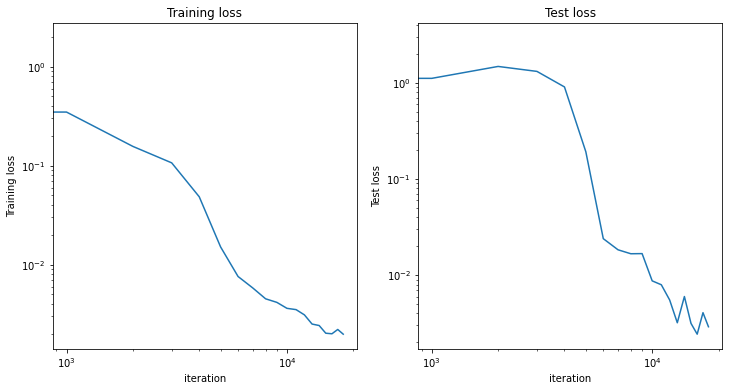

In [25]:
fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (12, 6))

ax = axs[0]
ax.plot(iterations,losses_tr)
ax.set_title('Training loss')
ax.set_xlabel('iteration')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('Training loss')

ax = axs[1]
ax.set_title('Test loss')
ax.plot(iterations,losses_test)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('iteration')
ax.set_ylabel('Test loss')

# Predictions

In [26]:
# Get prediction as numpy array
x_pred = test_orbit["x_pred"]
dp_pred = test_orbit["dp_pred"]
f_pred = test_orbit["f_pred"]

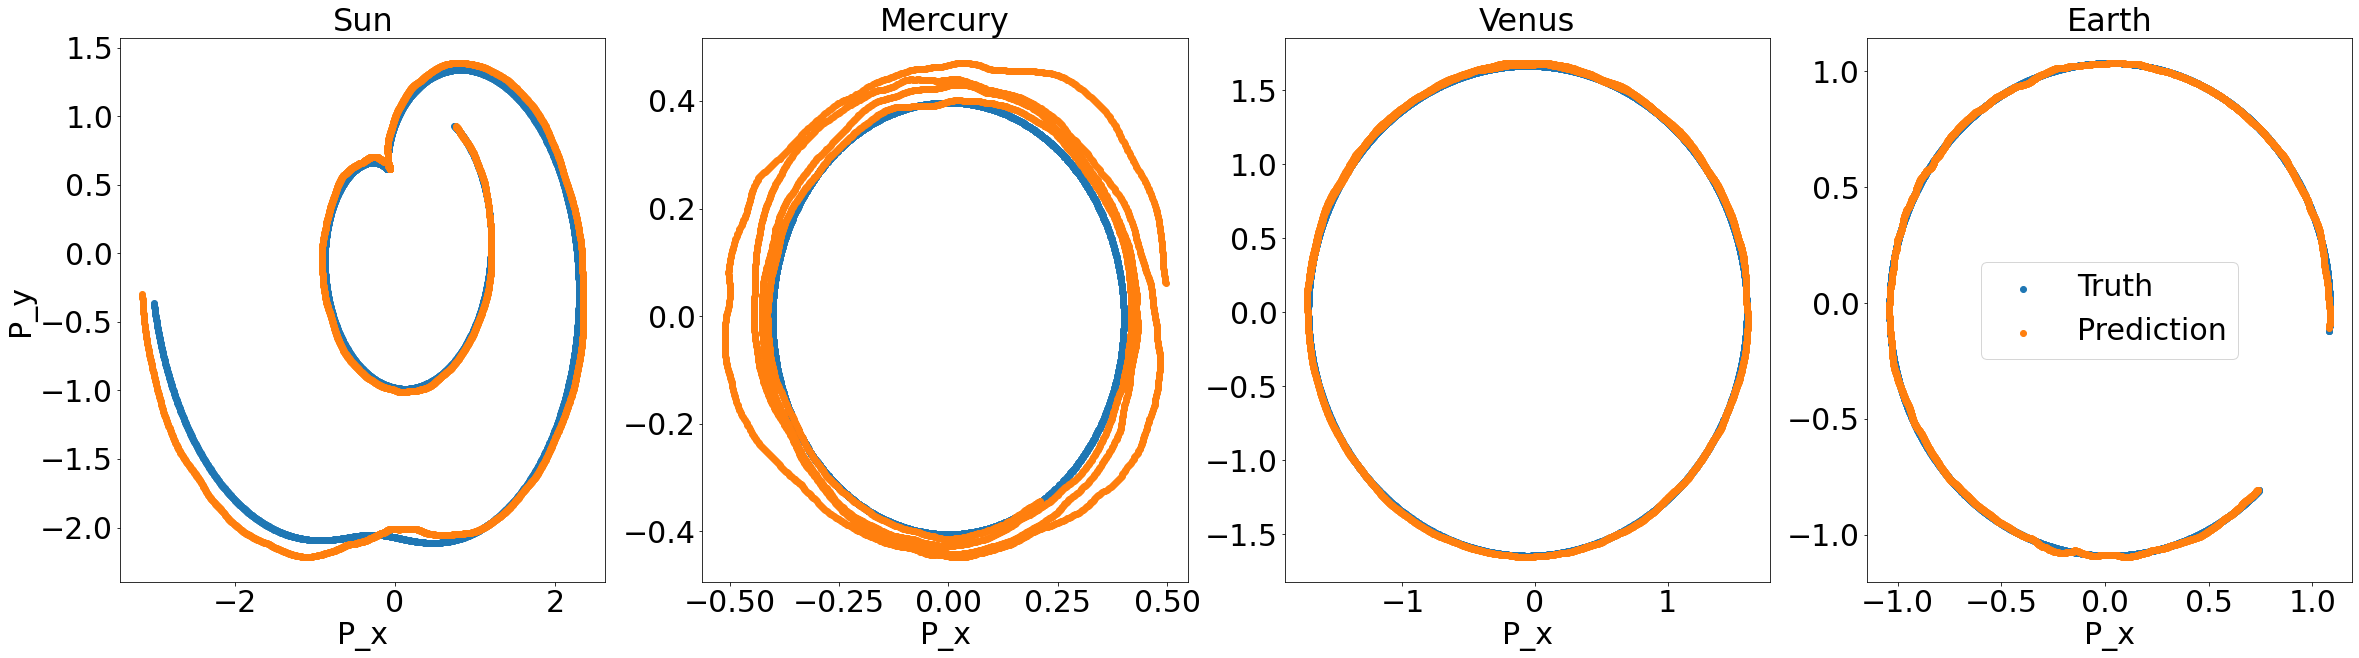

In [27]:
nsteps_plot = num_time_steps_test-1
plt.rcParams.update({'font.size': 30})
fig, axs =plt.subplots(nrows = 1, ncols = len(planets), figsize = (10*len(planets), 10))

periods = np.array([225, 88, 225, 1000, 1500])
factor = 10*periods

axs[0].set_ylabel('P_y')
for i in range(len(planets)):
    ax = axs[i]
    
    shift = dp_traj_np[:,i,0].max()/factor[i]*np.arange(nsteps_plot)

    ax.set_title(planets[i].name, fontsize = 32)
    ax.scatter(dp_traj_np[:nsteps_plot,i,0]/p_norm+shift, dp_traj_np[:nsteps_plot,i,1]/p_norm+shift, label='Truth')
    ax.scatter(dp_pred[:nsteps_plot,i,0]+shift, dp_pred[:nsteps_plot,i,1]+shift, label='Prediction')
    ax.set_xlabel('P_x')

plt.legend();

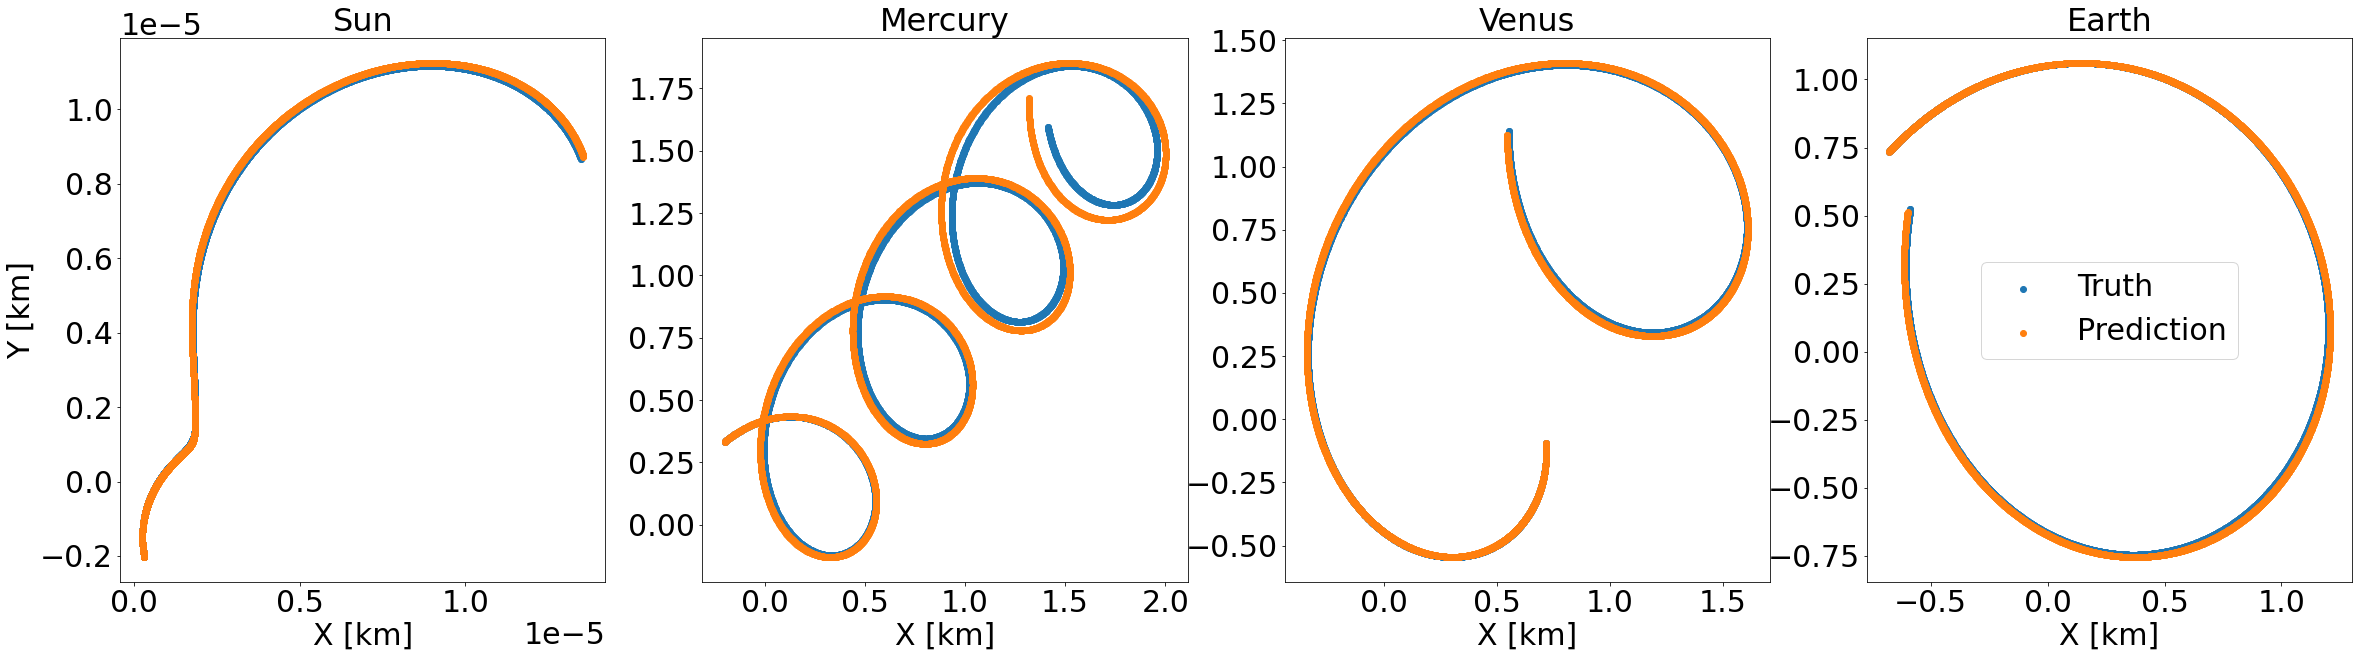

In [28]:
nsteps_plot = num_time_steps_test
plt.rcParams.update({'font.size': 30})
fig, axs =plt.subplots(nrows = 1, ncols = len(planets), figsize = (10*len(planets), 10))

periods = np.array([225, 88, 225, 1000, 1500])
factor = 10*periods

axs[0].set_ylabel('Y [km]')
for i in range(len(planets)):
    ax = axs[i]
    
    shift = x_traj_np[:,i,0].max()/factor[i]*np.arange(nsteps_plot)

    ax.set_title(planets[i].name, fontsize = 32)
    ax.scatter(x_traj_np[:nsteps_plot,i,0]+shift, x_traj_np[:nsteps_plot,i,1]+shift, label='Truth')
    ax.scatter(x_pred[:nsteps_plot,i,0]+shift, x_pred[:nsteps_plot,i,1]+shift, label='Prediction')
    ax.set_xlabel('X [km]')

plt.legend();